In [101]:
# Third-party imports,
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split

"""SPECIFICATIONS"""
SPEC = "IllustrisTNG_CV_z=0"
input_UNITS = r"$M_{\odot}/h/(Mpc/h)^3$"
target_UNITS = r"$(Mpc/h)^{-3}$"
input_QUANTITY = "Dark Matter Density"
target_QUANTITY = "Electron Number Density"

# Loading data files,
X = np.load(r"..//CAMELs//IllustrisTNG_CV_z=0//Grids_Mcdm_IllustrisTNG_CV_256_z=0.0.npy", mmap_mode='r')
Y = np.load(r"..//CAMELs//IllustrisTNG_CV_z=0//Grids_ne_IllustrisTNG_CV_256_z=0.0.npy", mmap_mode='r')

# Stage 1 - Scaling & Normalisation

In [92]:
# Functions,
def MinMaxNorm(data, epsilon=1e-6):
    min_val = np.min(data, axis=(1, 2), keepdims=True)
    max_val = np.max(data, axis=(1, 2), keepdims=True)
    return (data - min_val)/(max_val - min_val)

# Considering only a small subset of the data,
X, Y = X[0:5], Y[0:5]

# Reshaping the list of grids (3D) into a list of images (2D),
X = X.reshape(-1, X.shape[2], X.shape[3])
Y = Y.reshape(-1, Y.shape[2], Y.shape[3])

# Applying logarithmic transform,
X, Y = np.log(X), np.log(Y)

# Applying Min-Max normalisation,
X, Y = MinMaxNorm(X), MinMaxNorm(Y)

# Data Visualiser

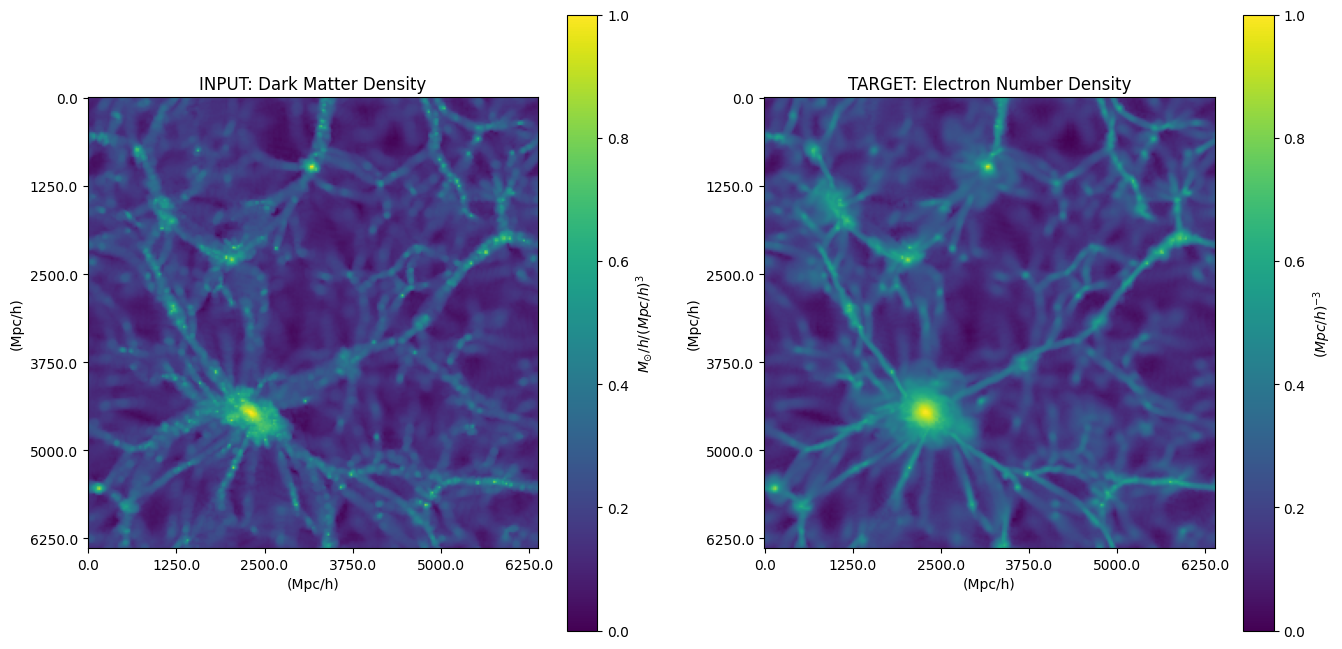

In [93]:
def plot_XYpair(image1, image2):
    """Plots the ith slice of the a 3D grid."""

    # Creating figure, axis and image,
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    img1 = axes[0].imshow(image1)
    img2 = axes[1].imshow(image2)

    # Setting labels,
    axes[0].set_xlabel("(Mpc/h)")
    axes[0].set_ylabel("(Mpc/h)")
    axes[0].set_title("INPUT: " + input_QUANTITY)

    axes[1].set_xlabel("(Mpc/h)")
    axes[1].set_ylabel("(Mpc/h)")
    axes[1].set_title("TARGET: " + target_QUANTITY)

    # Custom xtick and ytick labels,
    def custom_formatter(x, pos):
        return f'{x*25}'

    # Setting formatter,
    FORMATTER = FuncFormatter(custom_formatter)
    axes[0].xaxis.set_major_formatter(FORMATTER)
    axes[0].yaxis.set_major_formatter(FORMATTER)
    axes[1].xaxis.set_major_formatter(FORMATTER)
    axes[1].yaxis.set_major_formatter(FORMATTER)

    # Adding color bar,
    cbar1 = plt.colorbar(img1, ax=axes[0], orientation="vertical")
    cbar1.set_label(input_UNITS)
    cbar1 = plt.colorbar(img2, ax=axes[1], orientation="vertical")
    cbar1.set_label(target_UNITS)

    # Showing plot,
    plt.show()

"""VISUALISATION"""
i = 8
plot_XYpair(X[i], Y[i])


# Stage 2 - Training, Testing and Validation Split

In [94]:
# Defining the split,
TRAIN_PROP = 0.7
VALIDATION_PROP = 0.15
TEST_PROP = 0.15
RANDOM_STATE = 38

# Creating explicit indices,
data_length = X.shape[0]
data_indices = np.arange(start = 0, stop = data_length, step = 1)

# Shuffling the indices,
np.random.shuffle(data_indices)

# Split indices into train and temp (val+test),
train_indices, temp_indices = train_test_split(data_indices, test_size = (VALIDATION_PROP + TEST_PROP), random_state = RANDOM_STATE)

# Further split temp into validation and test,
val_indices, test_indices = train_test_split(temp_indices, test_size = (TEST_PROP/(VALIDATION_PROP + TEST_PROP)), random_state = RANDOM_STATE)

# Creating training, testing and validation data,
X_train, Y_train = X[train_indices], Y[train_indices]
X_test, Y_test = X[test_indices], Y[test_indices]
X_val, Y_val = X[val_indices], Y[val_indices]

# Stage 3 - Create TF Datasets

In [95]:
# Functions,
def serialise_example(x, y):
    """Serialises an (X,Y) pair for effficient storage."""
    feature = {
        "X_data": tf.train.Feature(float_list=tf.train.FloatList(value=x.flatten())),
        "Y_data": tf.train.Feature(float_list=tf.train.FloatList(value=y.flatten())),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def save_to_tfrecord(X, Y, filename):
    """Write the dataset to a file on the disk."""
    with tf.io.TFRecordWriter(filename) as writer:
        for i in range(len(X)):
            example = serialise_example(X[i], Y[i])
            writer.write(example)
    print(f"Saved: {filename}")

def add_channel(array):
    """Adds an additonal dimension for the image channel."""
    return np.expand_dims(array, axis = -1)

# Adding channel dimension (TF uses channel first scheme),
X_train, Y_train = add_channel(X_train), add_channel(Y_train)
X_test, Y_test = add_channel(X_test), add_channel(Y_test)
X_val, Y_val = add_channel(X_val), add_channel(Y_val)

# Saving to dataset to record files,
save_to_tfrecord(X_train, Y_train, "training_dataset.tfrecord")
save_to_tfrecord(X_test, Y_test, "testing_dataset.tfrecord")
save_to_tfrecord(X_val, Y_val, "validation_dataset.tfrecord")

Saved: training_dataset.tfrecord
Saved: testing_dataset.tfrecord
Saved: validation_dataset.tfrecord
